In [1]:
!pip install colorednoise > /dev/null

## About

In this notebook, I will introduce some basic Data Augmentation methods for audio. Similar in computer vision, Data Augmentation is quite effective for audio as well to make generalized model.

Maybe you'll find some odd translation since I translated this from Japanese and in some part I just used the result of deepL...

In [2]:
import librosa
import librosa.display

import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from IPython.display import Audio

Data Augmentations for audio is quite different from those for images. There are two types of augmentations:

1. Augmentations for waveform
2. Augmentations for spectrogram/melspectrogram

Augmentation for waveform is applied to raw 1D signal, and changes how it sounds like, so we can check how it alters the signal by listening it.
On the other hand, augmentation for spectrogram is something similar to image augmentation. However, spectrogram has some big differences from natural image.
One of the biggest difference is that it has axis - time axis and frequency axis. Applying augmentations that ignores this axis (Flip, Rotation, etc...) is nonsense.

## Data Loading




In [3]:
DATA_DIR = Path("../input/rfcx-species-audio-detection/train")

In [4]:
flacfiles = list(DATA_DIR.glob("*.flac"))
y, sr = librosa.load(flacfiles[0], duration=10)
y, sr

(array([0.00310208, 0.00046581, 0.00010771, ..., 0.00031397, 0.00807502,
        0.00311749], dtype=float32),
 22050)


Now we've loaded audio data. In this notebook, we'll apply several Data Augmentations and check the result by listening or visually watching it.

In [5]:
Audio(y, rate=sr)

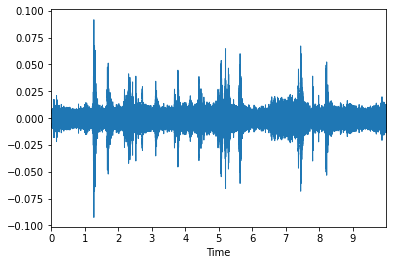

In [6]:
librosa.display.waveplot(y, sr=sr);

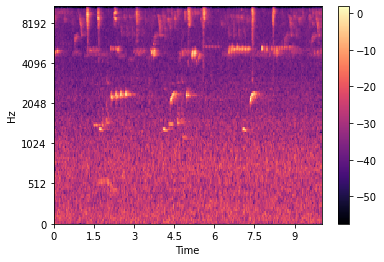

In [7]:
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y, sr=sr, n_mels=128))
librosa.display.specshow(melspec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar();

Data Augmentation (Data Augmentation for waveform)


Here, I'll introduce some Data Augmentation methods for raw waveform.

1. AddGaussianNoise
2. GaussianNoiseSNR
3. PinkNoiseSNR
4. PitchShift
5. TimeStretch
6. TimeShift
7. VolumeControl

I imitated the implementation of [albumentations](https://github.com/albumentations-team/albumentations).

In [8]:
class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, y: np.ndarray):
        if self.always_apply:
            return self.apply(y)
        else:
            if np.random.rand() < self.p:
                return self.apply(y)
            else:
                return y

    def apply(self, y: np.ndarray):
        raise NotImplementedError


class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray):
        for trns in self.transforms:
            y = trns(y)
        return y


class OneOf:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray):
        n_trns = len(self.transforms)
        trns_idx = np.random.choice(n_trns)
        trns = self.transforms[trns_idx]
        return trns(y)

### AddGaussianNoise



Add noise that follows normal distribution (a.k.a whitenoise). The amplitude of noise is randomly decided.

Reference: [Data Augmentation for Audio](https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6)

In [9]:
class AddGaussianNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_noise_amplitude=0.5, **kwargs):
        super().__init__(always_apply, p)

        self.noise_amplitude = (0.0, max_noise_amplitude)

    def apply(self, y: np.ndarray, **params):
        noise_amplitude = np.random.uniform(*self.noise_amplitude)
        noise = np.random.randn(len(y))
        augmented = (y + noise * noise_amplitude).astype(y.dtype)
        return augmented

In [10]:
transform = AddGaussianNoise(always_apply=True, max_noise_amplitude=0.05)
y_gaussian_added = transform(y)
Audio(y_gaussian_added, rate=sr)

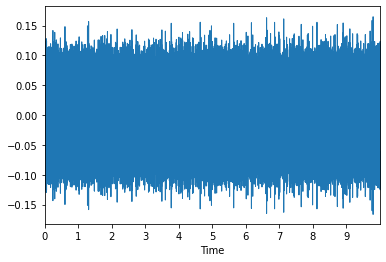

In [11]:
librosa.display.waveplot(y_gaussian_added, sr=sr);

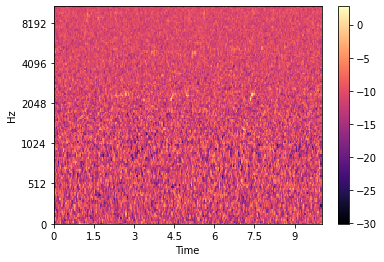

In [12]:
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y_gaussian_added, sr=sr, n_mels=128))
librosa.display.specshow(melspec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar();

### GaussianNoiseSNR

The problem with Data Augmentation introduced above is that if you specify an amplitude of noise, it can be masked by noise when the original signal is weak.

To prevent this, it is easier to adaptively set an appropriate noise level based on the amplitude of the signal in the original sound.

The ratio of the signal-to-noise level is called Signal-to-Noise Ratio (SNR). The signal-to-noise ratio (SNR) is expressed as the ratio of the actual amplitude to the logarithm of the signal's amplitude and is calculated by the following formula.

$$
SNR = 20\log_{10}\frac{A_{signal}}{A_{noise}}
$$

The larger this amount is, the stronger the signal, or the more audible the sound is, and it is expressed in dB (decibel), where 0dB means that the strength of the signal is balanced with the strength of the noise, when it is negative, the noise is stronger, and when it is positive, the signal is stronger.

There may be several ways to estimate the strength of the signal sound, but in this case we will treat the absolute maximum of the amplitude in the clip as the amplitude of the signal.

Reference: [任意のSignal-to-Noise比の音声波形をPythonで作ろう！](https://engineering.linecorp.com/ja/blog/voice-waveform-arbitrary-signal-to-noise-ratio-python/) (Japanese)

In [13]:
class GaussianNoiseSNR(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5.0, max_snr=20.0, **kwargs):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        white_noise = np.random.randn(len(y))
        a_white = np.sqrt(white_noise ** 2).max()
        augmented = (y + white_noise * 1 / a_white * a_noise).astype(y.dtype)
        return augmented

In [14]:
transform = GaussianNoiseSNR(always_apply=True, min_snr=5, max_snr=20)
y_gaussian_snr = transform(y)
Audio(y_gaussian_snr, rate=sr)

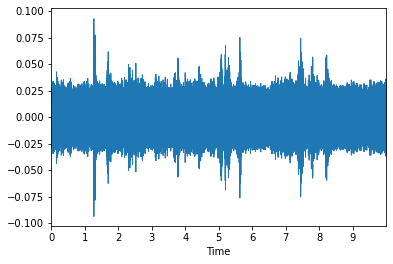

In [15]:
librosa.display.waveplot(y_gaussian_snr, sr=sr);

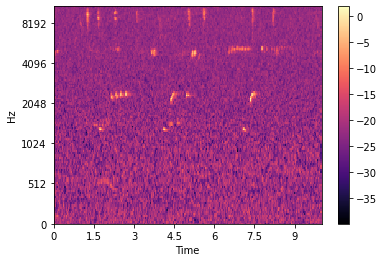

In [16]:
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y_gaussian_snr, sr=sr, n_mels=128))
librosa.display.specshow(melspec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar();

### PinkNoiseSNR


Gaussian Noise is a so-called white noise, which is a noise over the whole frequency range. Pink noise, which we introduce here, is noise with a gradual decrease in noise intensity from low frequency to low frequency bands. The noise in the natural world is said to be such noise.

The noise other than white noise is called "colored noise", and various noises such as brown noise and blue noise have been proposed.

The `colorednoise` library is used to generate pink noise, and its name comes from the above.

In the previous article, we introduced an implementation of white noise that directly specifies the intensity of the noise.

Reference: [Wikipedia Colors of noise](https://en.wikipedia.org/wiki/Colors_of_noise), [`colorednoise`](https://github.com/felixpatzelt/colorednoise)

In [17]:
import colorednoise as cn


class PinkNoiseSNR(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5.0, max_snr=20.0, **kwargs):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
        a_pink = np.sqrt(pink_noise ** 2).max()
        augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
        return augmented

In [18]:
transform = PinkNoiseSNR(always_apply=True, min_snr=5.0, max_snr=20.0)
y_pink_noise = transform(y)
Audio(y_pink_noise, rate=sr)

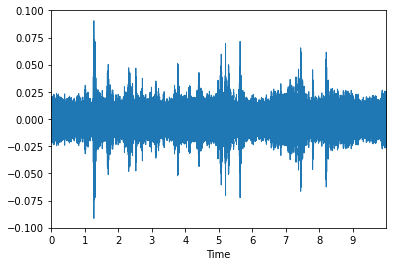

In [19]:
librosa.display.waveplot(y_pink_noise, sr=sr);

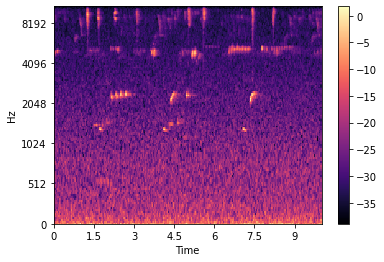

In [20]:
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y_pink_noise, sr=sr, n_mels=128))
librosa.display.specshow(melspec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar();

### PitchShift


PitchShift is a data augmentation that adjusts the pitch of the sound (high and low), making the sound heard as an effect higher/lower. On the Meru spectrogram, certain frequency bands in the pattern will be shifted up or down.

PitchShift takes more time than the previously introduced Data Augmentation because of resampling, and you should be careful not to change the pitch too much because it may cause the sound to crack.

Reference: [librosa.effects.pitch_shift](http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.effects.pitch_shift.html)

In [21]:
class PitchShift(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_steps=5, sr=32000):
        super().__init__(always_apply, p)

        self.max_steps = max_steps
        self.sr = sr

    def apply(self, y: np.ndarray, **params):
        n_steps = np.random.randint(-self.max_steps, self.max_steps)
        augmented = librosa.effects.pitch_shift(y, sr=self.sr, n_steps=n_steps)
        return augmented

In [22]:
transform = PitchShift(always_apply=True, max_steps=5, sr=sr)
y_pitch_shift = transform(y)
Audio(y_pitch_shift, rate=sr)

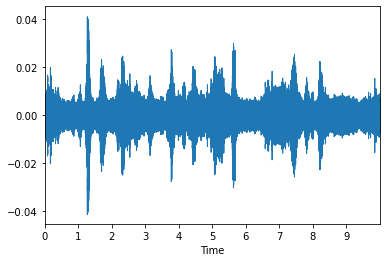

In [23]:
librosa.display.waveplot(y_pitch_shift, sr=sr);

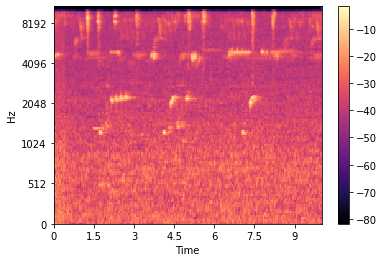

In [24]:
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y_pitch_shift, sr=sr, n_mels=128))
librosa.display.specshow(melspec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar();

### TimeStretch


TimeStretch stretches and compresses the original sound in time. As a result, the speed of the sound may be increased or decreased.

TimeStretch is another time-consuming form of data augmentation.

Reference: [librosa.effects.time_stretch](http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.effects.time_stretch.html)

In [25]:
class TimeStretch(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_rate=1.2):
        super().__init__(always_apply, p)

        self.max_rate = max_rate

    def apply(self, y: np.ndarray, **params):
        rate = np.random.uniform(0, self.max_rate)
        augmented = librosa.effects.time_stretch(y, rate)
        return augmented

In [26]:
transform = TimeStretch(always_apply=True, max_rate=2.0)
y_time_stretch = transform(y)
Audio(y_time_stretch, rate=sr)

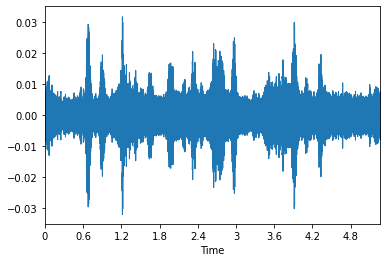

In [27]:
librosa.display.waveplot(y_time_stretch, sr=sr);

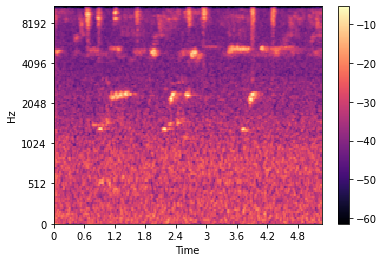

In [28]:
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y_time_stretch, sr=sr, n_mels=128))
librosa.display.specshow(melspec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar();

### TimeShift

TimeShift is such an operation that shifts a sound event in time. As for dealing with the part of the sound clip that goes out of the original length as a result of shifting, you can bring it forward (or backward) and stick it to the front (or backward), or ignore it and throw it away.

Reference: [Data Augmentation for Audio](https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6)

In [29]:
class TimeShift(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_shift_second=2, sr=32000, padding_mode="replace"):
        super().__init__(always_apply, p)
    
        assert padding_mode in ["replace", "zero"], "`padding_mode` must be either 'replace' or 'zero'"
        self.max_shift_second = max_shift_second
        self.sr = sr
        self.padding_mode = padding_mode

    def apply(self, y: np.ndarray, **params):
        shift = np.random.randint(-self.sr * self.max_shift_second, self.sr * self.max_shift_second)
        augmented = np.roll(y, shift)
        if self.padding_mode == "zero":
            if shift > 0:
                augmented[:shift] = 0
            else:
                augmented[shift:] = 0
        return augmented

In [30]:
transform = TimeShift(always_apply=True, max_shift_second=4, sr=sr)
y_time_shifted = transform(y)
Audio(y_time_shifted, rate=sr)

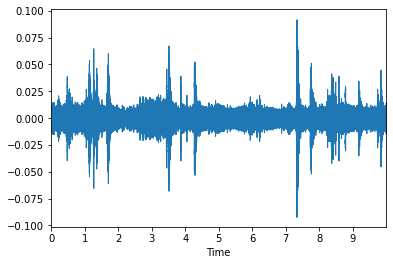

In [31]:
librosa.display.waveplot(y_time_shifted, sr=sr);

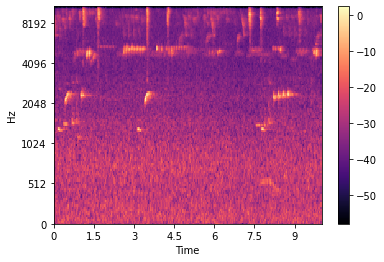

In [32]:
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y_time_shifted, sr=sr, n_mels=128))
librosa.display.specshow(melspec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar();

### VolumeControl

VolumeControl controls the volume. I think I mentioned before that the SNR has more influence on sound perception than the volume itself, but adjusting the volume causes a very small change in the mel spectrogram. Adjusting the volume according to a sine curve, cosine curve, etc. is also useful because it causes a big change in the mel spectrogram.

In [33]:
class VolumeControl(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, db_limit=10, mode="uniform"):
        super().__init__(always_apply, p)

        assert mode in ["uniform", "fade", "fade", "cosine", "sine"], \
            "`mode` must be one of 'uniform', 'fade', 'cosine', 'sine'"

        self.db_limit= db_limit
        self.mode = mode

    def apply(self, y: np.ndarray, **params):
        db = np.random.uniform(-self.db_limit, self.db_limit)
        if self.mode == "uniform":
            db_translated = 10 ** (db / 20)
        elif self.mode == "fade":
            lin = np.arange(len(y))[::-1] / (len(y) - 1)
            db_translated = 10 ** (db * lin / 20)
        elif self.mode == "cosine":
            cosine = np.cos(np.arange(len(y)) / len(y) * np.pi * 2)
            db_translated = 10 ** (db * cosine / 20)
        else:
            sine = np.sin(np.arange(len(y)) / len(y) * np.pi * 2)
            db_translated = 10 ** (db * sine / 20)
        augmented = y * db_translated
        return augmented

In [34]:
transform = VolumeControl(always_apply=True, mode="sine")
y_volume_controlled = transform(y)
Audio(y_volume_controlled, rate=sr)

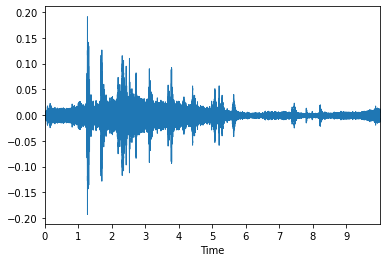

In [35]:
librosa.display.waveplot(y_volume_controlled, sr=sr);

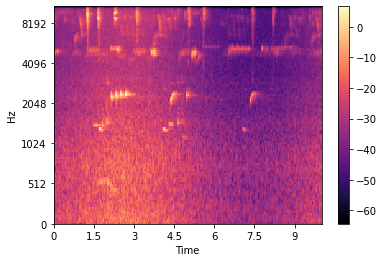

In [36]:
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y_volume_controlled, sr=sr, n_mels=128))
librosa.display.specshow(melspec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar();

### Combination

In [37]:
transform = Compose([
  OneOf([
    GaussianNoiseSNR(min_snr=10),
    PinkNoiseSNR(min_snr=10)
  ]),
  PitchShift(max_steps=2, sr=sr),
  TimeStretch(),
  TimeShift(sr=sr),
  VolumeControl(mode="sine")
])
y_composed = transform(y)
Audio(y_composed, rate=sr)

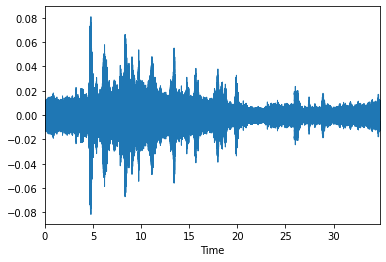

In [38]:
librosa.display.waveplot(y_composed, sr=sr);

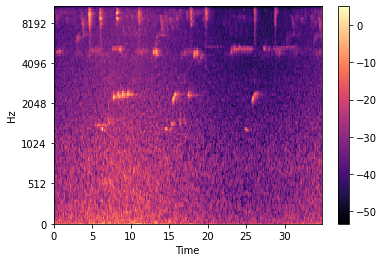

In [39]:
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y_composed, sr=sr, n_mels=128))
librosa.display.specshow(melspec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar();